CIFAR-10 is a subset of an 80 million image collection, with 60,000 images in total. The training data consists of 50k images, while the test data contains 10k images. The CIFAR-10 dataset consists of 10 categories with each category containing 6000 images.


Our focus in this notebook will be on PyTorch for building and training on the CIFAR10 Dataset. PyTorch simplifies the learning process.


# Importing the libraires required to run the CIFAR10 pytorch program

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torchvision.models as models
import time
import torchvision
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Extract and download the dataset

the dataset has 100 batches and each batch will have 60000/100 = 6000 images and the test batch will have total of 10 k images

In [2]:
def reshapedataset():
    transform_train = transforms.Compose([transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
    transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
    #transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
   # batch_size = 128
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform_train)
   

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=transform_train)
    

    return trainset, testset



# Set up the device and set the parameters


In [3]:
#set the device 

torch.cuda.is_available()
print('torch.cuda.is_available():', torch.cuda.is_available())
torch.cuda.current_device()
torch.cuda.get_device_name()
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
device

torch.cuda.is_available(): True


device(type='cuda', index=0)

# Building Neural Network Model

We have built a Neural network Model of 5 hidden layers. Since we have colour images our dataset will be divided into numeric values of RGB.The first layer is with input node [3072,1024,512,64,64,10]. Forward pass will use Rectified Activation unit(ReLu) which is easy to compute. To avoid activating all the nodes a transistion node is used.


In [4]:
#Create fully connected Network

class NN(nn.Module): #inherit from nn.module#
    
    def __init__(self):
        super(NN,self).__init__()
        self.fc1 = nn.Linear(3072,1024)# input layer and first layer
       
        self.fc2 =  nn.Linear(1024,512)#second layer and output layer#
       # self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512,64)
       # self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64,64)
       # self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(64,10)
        #self.activation_functions = activation_functions
    def forward(self,xb):
        out = xb.view(xb.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        return out
    


In [5]:
#Create fully connected Network

class NN_ss(nn.Module): #inherit from nn.module#
    
    def __init__(self):
        super(NN_ss,self).__init__()
        self.fc1 = nn.Linear(3072,1024)# input layer and first layer
       
        self.fc2 =  nn.Linear(1024,512)#second layer and output layer#
        
        self.fc3 = nn.Linear(512,64)
        
        self.fc4 = nn.Linear(64,64)
        

        self.fc5 = nn.Linear(64,10)
        #self.activation_functions = activation_functions
    def forward(self,xb):
        out = xb.view(xb.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.sigmoid(out)
        out = self.fc4(out)
        out = F.softmax(out)
        out = self.fc5(out)
        return out

# Predicting the accuracy

Accuracy is predicted by number of correct prediction out of total predictions

In [6]:

def checklossaccuracy(loader, model,nameofdataset):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x , y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            #x= x.reshape(x.shape[0],-1)
            
            scores = model(x)
            _, predictions = scores.max(1) #max of the second dimension,gives the index
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            loss = loss_criteria(scores,y)
            acc = num_correct/num_samples
        #print(f'Got{num_correct/num_samples} with accuracy {float(num_correct)/float(num_samples)*100}', nameofdataset)
        
    model.train()
    return loss,acc
    

In [7]:
def confusionmatrix(model,test_loader):
  num_correct = 0
  num_samples = 0
  for x , y in test_loader:
              x = x.to(device=device)
              y = y.to(device=device)
              #x= x.reshape(x.shape[0],-1)
              
              scores = model(x)
              _, predictions = scores.max(1) 
           
              
              conf_m = confusion_matrix(y.detach().cpu().numpy(), predictions.detach().cpu().numpy())
              conf_m = pd.DataFrame(conf_m)
              plt.figure(figsize = (10,7))
              sns.heatmap(conf_m, annot=True)

In [8]:
def showgraph(train_loss,test_loss,train_accuracy,test_accuracy):
  plt.figure(figsize = (15,5))
  plt.subplot(1,2,1)
  plt.plot(train_loss,label = 'train')
  plt.plot(test_loss,label = 'test')
  plt.title('Losses on train and test data')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(train_accuracy,label = 'train')
  plt.plot(test_accuracy,label = 'test')
  
  plt.title('Accuracies on train and test data')
  plt.legend()
  plt.subplots_adjust(left=0.1,
                          bottom=0.1, 
                          right=0.9, 
                          top=0.9, 
                          wspace=0.4, 
                          hspace=0.4)
  plt.show()

# Training the Model

Dataloader takes full advantage of our custom dataset class that inherits Dataset from torch library
 
 We have used Adam optimizer with betas and weight decay value.
 
 we first check the data for training set and validate the accuracy with the testing set

In [ ]:


batch_size = 64
num_epochs = 20

# Initialise Artifical Neural Network

model = NN().to(device)
#Loss and optimiser
loss_criteria = nn.CrossEntropyLoss()
learning_rate = 1e-3
betas=(0.9,0.995)
weight_decay=5e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas,weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum =0.9)
trainloader , testloader = reshapedataset()
train_loader = DataLoader(trainloader , batch_size= batch_size, shuffle = False )
test_loader = DataLoader(testloader , batch_size= batch_size, shuffle = False )
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(num_epochs):
    #check for each each batch loader from a tuple
    for batch, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(data.shape)
        #reshape to single vector , correct shape
        #trainloader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 

        data = data.reshape(data.shape[0],-1)
        #print(data.shape)
        scores = model(data)
        
        loss = loss_criteria(scores,targets)
        #print(scores)
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        
        #adam
        optimizer.step()
    trainloss,trainaccuracy = checklossaccuracy(train_loader,model,"Train")
    train_loss.append(trainloss)
    train_accuracy.append(trainaccuracy)
    testloss,testaccuracy = checklossaccuracy(test_loader,model,"Test")
    test_loss.append(testloss)
    test_accuracy.append(testaccuracy)
       
trainloss,trainaccuracy = checklossaccuracy(train_loader,model,"Train")
testloss,testaccuracy = checklossaccuracy(test_loader,model,"Test")
print("Train loss: {}, test loss:  {} ".format(float(trainloss),float(testloss)))
print("Train accuracy: {}, test accuracy:  {} ".format(float(trainaccuracy),float(testaccuracy)))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train loss: 0.6268842816352844, test loss:  1.1524940729141235 
Train accuracy: 0.611519992351532, test accuracy:  0.5254999995231628 


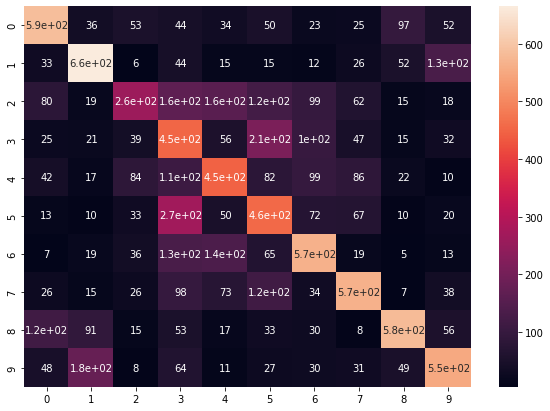

In [ ]:
confusionmatrix(model,DataLoader(testloader, batch_size=10000,shuffle=False, num_workers=2, pin_memory=True))

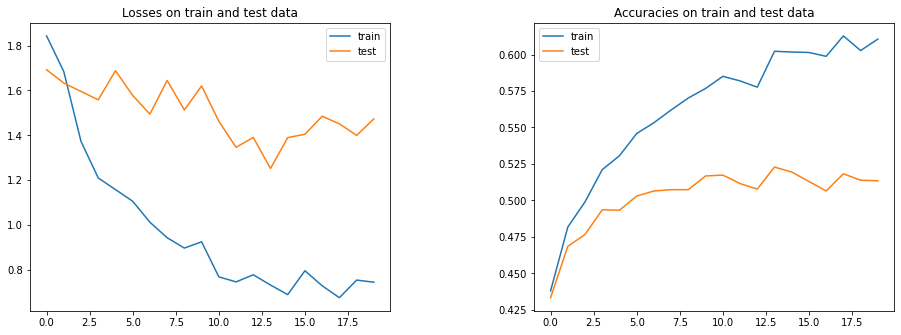

In [ ]:
showgraph(train_loss,test_loss,train_accuracy,test_accuracy)

# Conclusions - 1

As we can see above the accuracy for CIFAR 10 dataset with Neural network for training dataset is 63 % and testing is 51%. there is a difference of 12%. We can infer that Neural network is not successful in its prediction of images

Future to this we have tried with less Layers but still there is no much improvement in the accuracy.

Firstly let's try to tune the dataset and run the model to check how it is effecting the accuracy

In [ ]:
 def reshapedataset():
        transform_train = transforms.Compose([transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618),
                                  (0.24703225141799082, 0.24348516474564, 0.26158783926049628))
                                ])
        transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618),
                                      (0.24703225141799082, 0.24348516474564, 0.26158783926049628))])


        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                    download=True, transform=transform_train)
        

        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                   download=True, transform=transform_train)
        

        return trainset, testset



In [ ]:


batch_size = 64
num_epochs = 20

# Initialise Artifical Neural Network

model = NN().to(device)
#Loss and optimiser
loss_criteria = nn.CrossEntropyLoss()
betas=(0.9,0.995)
weight_decay=5e-4
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas,weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum =0.9)
trainloader , testloader = reshapedataset()
train_loader = DataLoader(trainloader , batch_size= batch_size, shuffle = False )
test_loader = DataLoader(testloader , batch_size= batch_size, shuffle = False )
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(num_epochs):
    #check for each each batch loader from a tuple
    train_losses = []
    train_accuracy = []
    for batch, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(data.shape)
        #reshape to single vector , correct shape
        #trainloader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 

        data = data.reshape(data.shape[0],-1)
        #print(data.shape)
        scores = model(data)
        
        loss = loss_criteria(scores,targets)
        #print(scores)
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        
        #adam
        optimizer.step()
    trainloss,trainaccuracy = checklossaccuracy(train_loader,model,"Train")
    train_loss.append(trainloss)
    train_accuracy.append(trainaccuracy)
    testloss,testaccuracy = checklossaccuracy(test_loader,model,"Test")
    test_loss.append(testloss)
    test_accuracy.append(testaccuracy)

trainloss,trainaccuracy = checklossaccuracy(train_loader,model,"Train")
testloss,testaccuracy = checklossaccuracy(test_loader,model,"Test")
print("Train loss: {}, test loss:  {} ".format(float(trainloss),float(testloss)))
print("Train accuracy: {}, test accuracy:  {} ".format(float(trainaccuracy),float(testaccuracy)))       


Files already downloaded and verified
Files already downloaded and verified
Train loss: 0.724656879901886, test loss:  1.530376672744751 
Train accuracy: 0.5970199704170227, test accuracy:  0.5094000101089478 


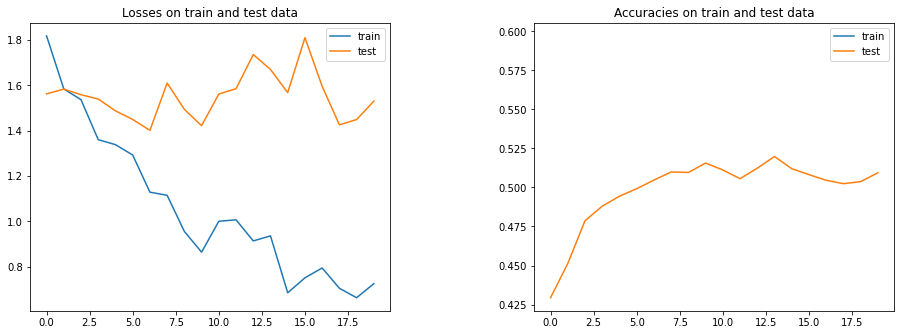

In [ ]:
showgraph(train_loss,test_loss,train_accuracy,test_accuracy)

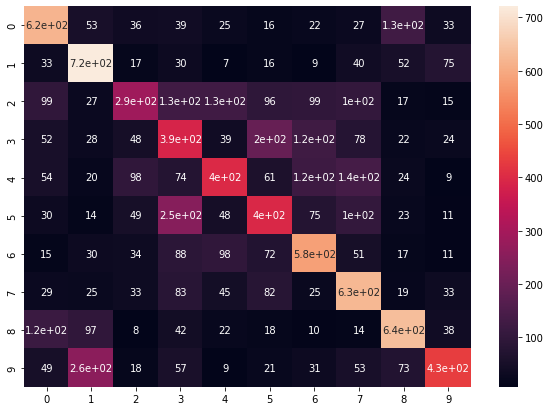

In [ ]:
confusionmatrix(model,DataLoader(testloader, batch_size=10000,shuffle=False, num_workers=2, pin_memory=True))

In [ ]:


batch_size = 64
num_epochs = 20

# Initialise Artifical Neural Network

model = NN_ss().to(device)
#Loss and optimiser
loss_criteria = nn.CrossEntropyLoss()
betas=(0.9,0.995)
weight_decay=5e-4
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas,weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum =0.9)
trainloader , testloader = reshapedataset()
train_loader = DataLoader(trainloader , batch_size= batch_size, shuffle = False )
test_loader = DataLoader(testloader , batch_size= batch_size, shuffle = False )
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(num_epochs):
    #check for each each batch loader from a tuple
    train_losses = []
    train_accuracy = []
    for batch, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(data.shape)
        #reshape to single vector , correct shape
        #trainloader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 

        data = data.reshape(data.shape[0],-1)
        #print(data.shape)
        scores = model(data)
        
        loss = loss_criteria(scores,targets)
        #print(scores)
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        
        #adam
        optimizer.step()
    trainloss,trainaccuracy = checklossaccuracy(train_loader,model,"Train")
    train_loss.append(trainloss)
    train_accuracy.append(trainaccuracy)
    testloss,testaccuracy = checklossaccuracy(test_loader,model,"Test")
    test_loss.append(testloss)
    test_accuracy.append(testaccuracy)

trainloss,trainaccuracy = checklossaccuracy(train_loader,model,"Train")
testloss,testaccuracy = checklossaccuracy(test_loader,model,"Test")
print("Train loss: {}, test loss:  {} ".format(float(trainloss),float(testloss)))
print("Train accuracy: {}, test accuracy:  {} ".format(float(trainaccuracy),float(testaccuracy)))       


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train loss: 1.8042449951171875, test loss:  2.0922913551330566 
Train accuracy: 0.26005998253822327, test accuracy:  0.2523999810218811 


In [ ]:


batch_size = 64
num_epochs = 20

# Initialise Artifical Neural Network

model = NN_ss().to(device)
#Loss and optimiser
loss_criteria = nn.CrossEntropyLoss()
betas=(0.9,0.995)
weight_decay=5e-4
learning_rate = 1e-3
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas,weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum =0.9)
trainloader , testloader = reshapedataset()
train_loader = DataLoader(trainloader , batch_size= batch_size, shuffle = False )
test_loader = DataLoader(testloader , batch_size= batch_size, shuffle = False )
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(num_epochs):
    #check for each each batch loader from a tuple
    train_losses = []
    train_accuracy = []
    for batch, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(data.shape)
        #reshape to single vector , correct shape
        #trainloader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 

        data = data.reshape(data.shape[0],-1)
        #print(data.shape)
        scores = model(data)
        
        loss = loss_criteria(scores,targets)
        #print(scores)
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        
        #adam
        optimizer.step()
    trainloss,trainaccuracy = checklossaccuracy(train_loader,model,"Train")
    train_loss.append(trainloss)
    train_accuracy.append(trainaccuracy)
    testloss,testaccuracy = checklossaccuracy(test_loader,model,"Test")
    test_loss.append(testloss)
    test_accuracy.append(testaccuracy)

trainloss,trainaccuracy = checklossaccuracy(train_loader,model,"Train")
testloss,testaccuracy = checklossaccuracy(test_loader,model,"Test")
print("Train loss: {}, test loss:  {} ".format(float(trainloss),float(testloss)))
print("Train accuracy: {}, test accuracy:  {} ".format(float(trainaccuracy),float(testaccuracy)))       


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train loss: 2.302370548248291, test loss:  2.302171230316162 
Train accuracy: 0.09999999403953552, test accuracy:  0.09999999403953552 


# Conclusions -2 

As we see still there is sigificant difference between Train and test accuracy and no much improvement lets add  dropout of p=0.2 in the Neural network Model

In [ ]:
class NN_dropout(nn.Module): #inherit from nn.module#
    
    def __init__(self,p):
        super(NN_dropout,self).__init__()
        #dropoutpercentage = 0.2

        self.fc1 = nn.Linear(3072,1024)# input layer and first layer
        self.dropout1 = nn.Dropout(p=p)
        self.fc2 = nn.Linear(1024,512)#second layer and output layer#
        self.dropout2 = nn.Dropout(p=p)
        self.fc3 = nn.Linear(512,64)
        self.dropout3 = nn.Dropout(p=p)
        
        self.fc4 = nn.Linear(64,64)
        self.dropout4 = nn.Dropout(p=p)

        self.fc5 = nn.Linear(64,10)
        self.dropout5 = nn.Dropout(p=p)
        
    def forward(self,xb):
        out = xb.view(xb.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        return out
    

In [ ]:


batch_size = 64
num_epochs = 20

# Initialise Artifical Neural Network

modeldropout = NN_dropout(p=0.2).to(device)
#Loss and optimiser
loss_criteria = nn.CrossEntropyLoss()
betas=(0.9,0.995)
weight_decay=5e-4
learning_rate = 1e-3
optimizer = optim.Adam(modeldropout.parameters(), lr=learning_rate, betas=betas,weight_decay=weight_decay)
#optimizer = optim.SGD(modeldropout.parameters(), lr=learning_rate, momentum = 0.9)

trainloader , testloader = reshapedataset()
train_loader = DataLoader(trainloader , batch_size= batch_size, shuffle = False )
test_loader = DataLoader(testloader , batch_size= batch_size, shuffle = False )
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(num_epochs):
    #check for each each batch loader from a tuple
    
    for batch, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(data.shape)
        #reshape to single vector , correct shape
        #trainloader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 

        data = data.reshape(data.shape[0],-1)
        #print(data.shape)
        scores = modeldropout(data)
        
        loss = loss_criteria(scores,targets)
        #print(scores)
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        
        #adam
        optimizer.step()
    trainloss,trainaccuracy = checklossaccuracy(train_loader,modeldropout,"Train")
    train_loss.append(trainloss)
    train_accuracy.append(trainaccuracy)
    testloss,testaccuracy = checklossaccuracy(test_loader,modeldropout,"Test")
    test_loss.append(testloss)
    test_accuracy.append(testaccuracy)
            
trainloss,trainaccuracy = checklossaccuracy(train_loader,modeldropout,"Train")
testloss,testaccuracy = checklossaccuracy(test_loader,modeldropout,"Test")
print("Train loss: {}, test loss:  {} ".format(float(trainloss),float(testloss)))
print("Train accuracy: {}, test accuracy:  {} ".format(float(trainaccuracy),float(testaccuracy)))


Files already downloaded and verified
Files already downloaded and verified
Train loss: 0.7913302779197693, test loss:  1.391546607017517 
Train accuracy: 0.5975799560546875, test accuracy:  0.5120999813079834 


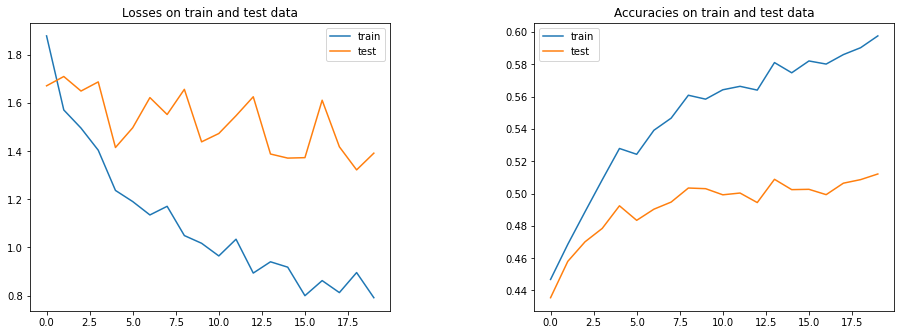

In [ ]:
showgraph(train_loss,test_loss,train_accuracy,test_accuracy)

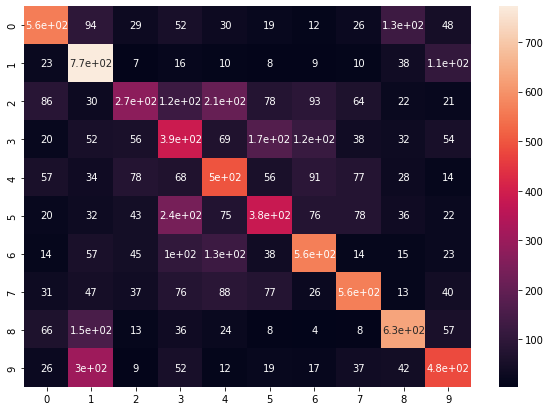

In [ ]:
confusionmatrix(modeldropout,DataLoader(testloader, batch_size=10000,shuffle=False, num_workers=2, pin_memory=True))


## Lets add a dropout of 0.5 and check how it is effecting the accuracy and make a conclusion on it

In [ ]:


batch_size = 64
num_epochs = 20

# Initialise Artifical Neural Network

modeldropout = NN_dropout(p=0.5).to(device)
#Loss and optimiser
loss_criteria = nn.CrossEntropyLoss()
betas=(0.9,0.995)
weight_decay=5e-4
learning_rate = 1e-3
optimizer = optim.Adam(modeldropout.parameters(), lr=learning_rate, betas=betas,weight_decay=weight_decay)
#optimizer = optim.SGD(modeldropout.parameters(), lr=learning_rate, momentum = 0.9)

trainloader , testloader = reshapedataset()
train_loader = DataLoader(trainloader , batch_size= batch_size, shuffle = False )
test_loader = DataLoader(testloader , batch_size= batch_size, shuffle = False )
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(num_epochs):
    #check for each each batch loader from a tuple
    
    for batch, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(data.shape)
        #reshape to single vector , correct shape
        #trainloader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 

        data = data.reshape(data.shape[0],-1)
        #print(data.shape)
        scores = modeldropout(data)
        
        loss = loss_criteria(scores,targets)
        #print(scores)
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        
        #adam
        optimizer.step()
    trainloss,trainaccuracy = checklossaccuracy(train_loader,modeldropout,"Train")
    train_loss.append(trainloss)
    train_accuracy.append(trainaccuracy)
    testloss,testaccuracy = checklossaccuracy(test_loader,modeldropout,"Test")
    test_loss.append(testloss)
    test_accuracy.append(testaccuracy)

trainloss,trainaccuracy = checklossaccuracy(train_loader,modeldropout,"Train")
testloss,testaccuracy = checklossaccuracy(test_loader,modeldropout,"Test")
print("Train loss: {}, test loss:  {} ".format(float(trainloss),float(testloss)))
print("Train accuracy: {}, test accuracy:  {} ".format(float(trainaccuracy),float(testaccuracy)))


Files already downloaded and verified
Files already downloaded and verified
Train loss: 0.8931864500045776, test loss:  1.4659643173217773 
Train accuracy: 0.5904200077056885, test accuracy:  0.5080000162124634 


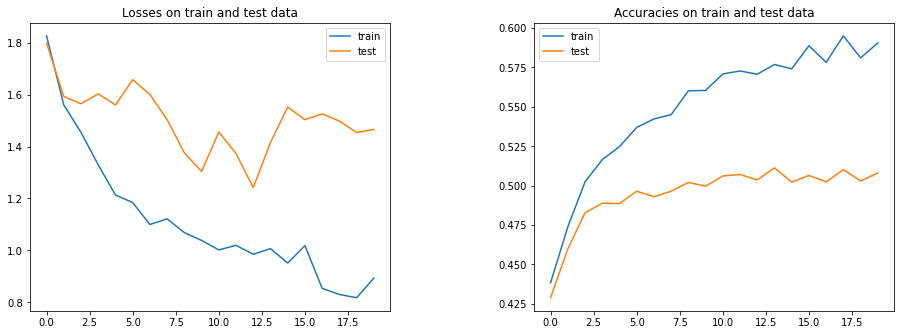

In [ ]:
showgraph(train_loss,test_loss,train_accuracy,test_accuracy)

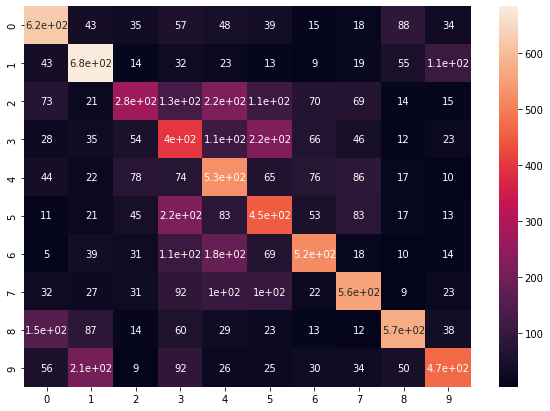

In [ ]:
confusionmatrix(modeldropout,DataLoader(testloader, batch_size=10000,shuffle=False, num_workers=2, pin_memory=True))

# Conclusions - 3

As we see there is no much difference between the dropout [0.2] and [0.5] added to the layers . We can conclude that Neural network is not the apt solution to predict CIFAR images.

We need to build a much higher evaluating model like CNN. 

# Building a CNN model

we have built a CNN model of 6 convo 2d layers,  Relu , Maxpool2d. We have also used the functionality such as BatchNormal and Flatten to tune it.

Lets check the accuracy of the model.

In [ ]:
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),
            

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:

batch_size = 64
num_epochs = 100

modelCNN = CnnModel().to(device)
#Loss and optimiser

loss_criteria = nn.CrossEntropyLoss()
betas=(0.9,0.995)
weight_decay=5e-4
learning_rate = 1e-3
optimizer = optim.Adam(modelCNN.parameters(), lr=learning_rate,betas=betas,weight_decay=weight_decay)
#optimizer = optim.SGD(modelCNN.parameters(), lr=learning_rate, momentum = 0.9)

trainloader , testloader = reshapedataset()
train_loader = DataLoader(trainloader , batch_size= batch_size, shuffle = False )
test_loader = DataLoader(testloader , batch_size= batch_size, shuffle = False )
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    #check for each each batch loader from a tuple
    
    for batch, (data, targets ) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(data.shape)
        #reshape to single vector , correct shape
        #trainloader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
        #print(data.shape)
        #data = data.reshape(data.shape[0],-1)
        #print(data.shape)
        scores = modelCNN(data)
        
        loss = loss_criteria(scores,targets)
        #print(scores)
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #adam
        optimizer.step()
    trainloss,trainaccuracy = checklossaccuracy(train_loader,modelCNN,"Train")
    train_loss.append(trainloss)
    train_accuracy.append(trainaccuracy)
    testloss,testaccuracy = checklossaccuracy(test_loader,modelCNN,"Test")
    test_loss.append(testloss)
    test_accuracy.append(testaccuracy)

trainloss,trainaccuracy = checklossaccuracy(train_loader,modelCNN,"Train")
testloss,testaccuracy = checklossaccuracy(test_loader,modelCNN,"Test")
print("Train loss: {}, test loss:  {} ".format(float(trainloss),float(testloss)))
print("Train accuracy: {}, test accuracy:  {} ".format(float(trainaccuracy),float(testaccuracy)))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train loss: 0.0920129343867302, test loss:  1.1423228979110718 
Train accuracy: 0.9679799675941467, test accuracy:  0.8260999917984009 


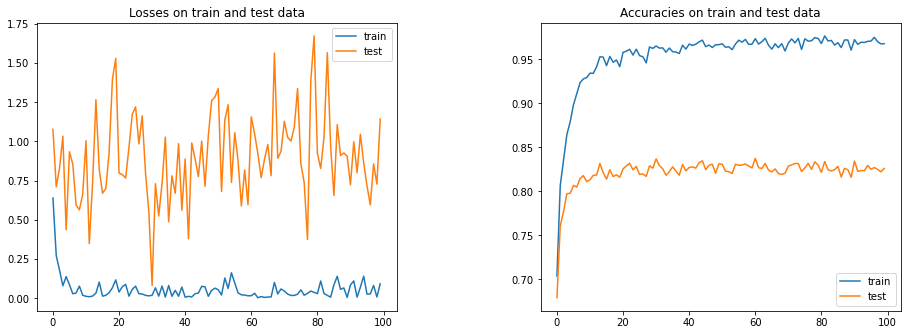

In [ ]:
showgraph(train_loss,test_loss,train_accuracy,test_accuracy)

In [ ]:
confusionmatrix(modelCNN,DataLoader(testloader, batch_size=10000,shuffle=False, num_workers=2, pin_memory=True))

# Conclusions -4

As we see there is drastic improvement in the accuracy of the model by using CNN. but still there is 13 % error rate between the training and the testing set. Lets add dropouts and check the error rate between both. 

In [10]:
class CnnModel(nn.Module):
    def __init__(self,dropout):
        super(CnnModel,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),
            

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:

batch_size = 64
num_epochs = 100

modelCNN = CnnModel(dropout = 0.2).to(device)
#Loss and optimiser
dropout = 0.2
loss_criteria = nn.CrossEntropyLoss()
betas=(0.9,0.995)
weight_decay=5e-4
learning_rate = 1e-3
optimizer = optim.Adam(modelCNN.parameters(), lr=learning_rate,betas=betas,weight_decay=weight_decay)
#optimizer = optim.SGD(modelCNN.parameters(), lr=learning_rate, momentum = 0.9)

trainloader , testloader = reshapedataset()
train_loader = DataLoader(trainloader , batch_size= batch_size, shuffle = False )
test_loader = DataLoader(testloader , batch_size= batch_size, shuffle = False )
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(num_epochs):
    #check for each each batch loader from a tuple
    
    for batch, (data, targets ) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(data.shape)
        #reshape to single vector , correct shape
        #trainloader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
        #print(data.shape)
        #data = data.reshape(data.shape[0],-1)
        #print(data.shape)
        scores = modelCNN(data)
        
        loss = loss_criteria(scores,targets)
        #print(scores)
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #adam
        optimizer.step()
    trainloss,trainaccuracy = checklossaccuracy(train_loader,modelCNN,"Train")
    train_loss.append(trainloss)
    train_accuracy.append(trainaccuracy)
    testloss,testaccuracy = checklossaccuracy(test_loader,modelCNN,"Test")
    test_loss.append(testloss)
    test_accuracy.append(testaccuracy)

trainloss,trainaccuracy = checklossaccuracy(train_loader,modelCNN,"Train")
testloss,testaccuracy = checklossaccuracy(test_loader,modelCNN,"Test")
print("Train loss: {}, test loss:  {} ".format(float(trainloss),float(testloss)))
print("Train accuracy: {}, test accuracy:  {} ".format(float(trainaccuracy),float(testaccuracy)))

Files already downloaded and verified
Files already downloaded and verified
Train loss: 0.13317014276981354, test loss:  0.552979588508606 
Train accuracy: 0.9126799702644348, test accuracy:  0.8190000057220459 


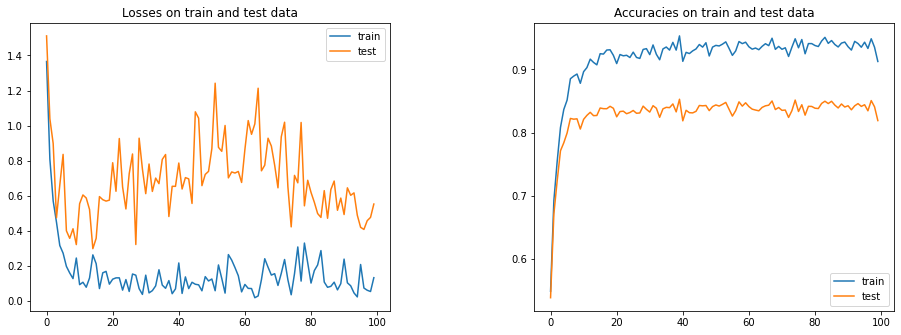

In [ ]:
showgraph(train_loss,test_loss,train_accuracy,test_accuracy)

In [ ]:
confusionmatrix(modelCNN,DataLoader(testloader, batch_size=10000,shuffle=False, num_workers=2, pin_memory=True))

In [ ]:

batch_size = 64
num_epochs = 100

modelCNN = CnnModel(dropout = 0.3).to(device)
#Loss and optimiser

loss_criteria = nn.CrossEntropyLoss()
betas=(0.9,0.995)
weight_decay=5e-4
learning_rate = 1e-3
optimizer = optim.Adam(modelCNN.parameters(), lr=learning_rate,betas=betas,weight_decay=weight_decay)
#optimizer = optim.SGD(modelCNN.parameters(), lr=learning_rate, momentum = 0.9)

trainloader , testloader = reshapedataset()
train_loader = DataLoader(trainloader , batch_size= batch_size, shuffle = False )
test_loader = DataLoader(testloader , batch_size= batch_size, shuffle = False )
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(num_epochs):
    #check for each each batch loader from a tuple
    
    for batch, (data, targets ) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(data.shape)
        #reshape to single vector , correct shape
        #trainloader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
        #print(data.shape)
        #data = data.reshape(data.shape[0],-1)
        #print(data.shape)
        scores = modelCNN(data)
        
        loss = loss_criteria(scores,targets)
        #print(scores)
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #adam
        optimizer.step()
    trainloss,trainaccuracy = checklossaccuracy(train_loader,modelCNN,"Train")
    train_loss.append(trainloss)
    train_accuracy.append(trainaccuracy)
    testloss,testaccuracy = checklossaccuracy(test_loader,modelCNN,"Test")
    test_loss.append(testloss)
    test_accuracy.append(testaccuracy)

trainloss,trainaccuracy = checklossaccuracy(train_loader,modelCNN,"Train")
testloss,testaccuracy = checklossaccuracy(test_loader,modelCNN,"Test")
print("Train loss: {}, test loss:  {} ".format(float(trainloss),float(testloss)))
print("Train accuracy: {}, test accuracy:  {} ".format(float(trainaccuracy),float(testaccuracy)))

Files already downloaded and verified
Files already downloaded and verified
Train loss: 0.5256924629211426, test loss:  0.5858408808708191 
Train accuracy: 0.8738399744033813, test accuracy:  0.798799991607666 


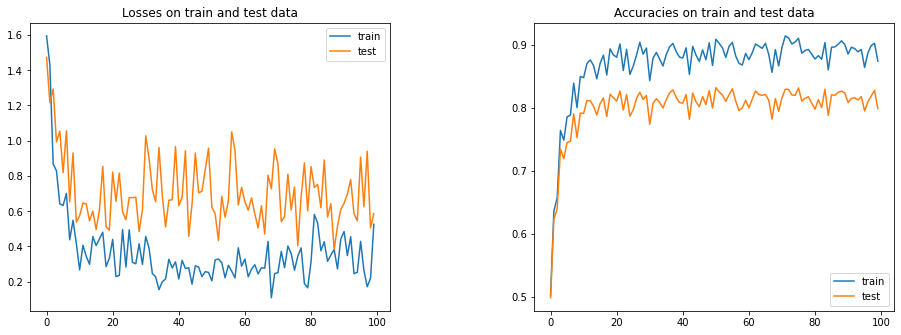

In [ ]:
showgraph(train_loss,test_loss,train_accuracy,test_accuracy)

In [ ]:
confusionmatrix(modelCNN,DataLoader(testloader, batch_size=10000,shuffle=False, num_workers=2, pin_memory=True))

In [ ]:

batch_size = 64
num_epochs = 100

modelCNN = CnnModel(dropout = 0.4).to(device)
#Loss and optimiser

loss_criteria = nn.CrossEntropyLoss()
betas=(0.9,0.995)
weight_decay=5e-4
learning_rate = 1e-3
optimizer = optim.Adam(modelCNN.parameters(), lr=learning_rate,betas=betas,weight_decay=weight_decay)
#optimizer = optim.SGD(modelCNN.parameters(), lr=learning_rate, momentum = 0.9)

trainloader , testloader = reshapedataset()
train_loader = DataLoader(trainloader , batch_size= batch_size, shuffle = False )
test_loader = DataLoader(testloader , batch_size= batch_size, shuffle = False )
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(num_epochs):
    #check for each each batch loader from a tuple
    
    for batch, (data, targets ) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(data.shape)
        #reshape to single vector , correct shape
        #trainloader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
        #print(data.shape)
        #data = data.reshape(data.shape[0],-1)
        #print(data.shape)
        scores = modelCNN(data)
        
        loss = loss_criteria(scores,targets)
        #print(scores)
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #adam
        optimizer.step()
    trainloss,trainaccuracy = checklossaccuracy(train_loader,modelCNN,"Train")
    train_loss.append(trainloss)
    train_accuracy.append(trainaccuracy)
    testloss,testaccuracy = checklossaccuracy(test_loader,modelCNN,"Test")
    test_loss.append(testloss)
    test_accuracy.append(testaccuracy)

trainloss,trainaccuracy = checklossaccuracy(train_loader,modelCNN,"Train")
testloss,testaccuracy = checklossaccuracy(test_loader,modelCNN,"Test")
print("Train loss: {}, test loss:  {} ".format(float(trainloss),float(testloss)))
print("Train accuracy: {}, test accuracy:  {} ".format(float(trainaccuracy),float(testaccuracy)))

Files already downloaded and verified
Files already downloaded and verified
Train loss: 0.4930853843688965, test loss:  0.766450047492981 
Train accuracy: 0.82778000831604, test accuracy:  0.7734000086784363 


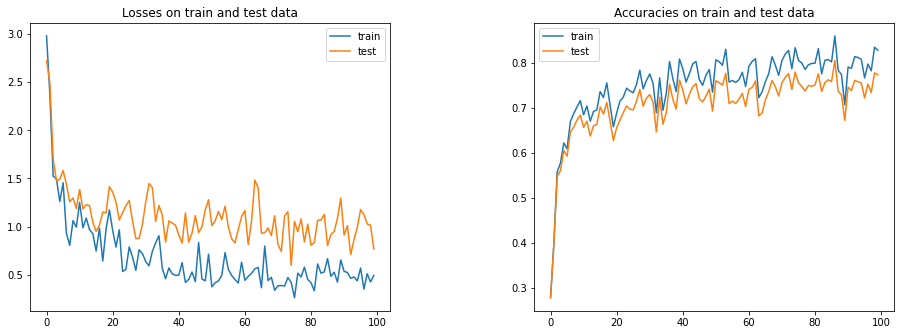

In [ ]:
showgraph(train_loss,test_loss,train_accuracy,test_accuracy)

# Conclusions 

As we clearly see we get the best accuracy of the model when the dropout is 0.2 and the error rate between the data is just 9-10%, we can consider this as our best working model


In [11]:

batch_size = 64
num_epochs = 100

modelCNN = CnnModel(dropout = 0.3).to(device)
#Loss and optimiser

loss_criteria = nn.CrossEntropyLoss()
betas=(0.9,0.995)
weight_decay=5e-4
learning_rate = 1e-3
#optimizer = optim.Adam(modelCNN.parameters(), lr=learning_rate,betas=betas,weight_decay=weight_decay)
optimizer = optim.SGD(modelCNN.parameters(), lr=learning_rate, momentum = 0.9)

trainloader , testloader = reshapedataset()
train_loader = DataLoader(trainloader , batch_size= batch_size, shuffle = False )
test_loader = DataLoader(testloader , batch_size= batch_size, shuffle = False )
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(num_epochs):
    #check for each each batch loader from a tuple
    
    for batch, (data, targets ) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(data.shape)
        #reshape to single vector , correct shape
        #trainloader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
        #print(data.shape)
        #data = data.reshape(data.shape[0],-1)
        #print(data.shape)
        scores = modelCNN(data)
        
        loss = loss_criteria(scores,targets)
        #print(scores)
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #adam
        optimizer.step()
    trainloss,trainaccuracy = checklossaccuracy(train_loader,modelCNN,"Train")
    train_loss.append(trainloss)
    train_accuracy.append(trainaccuracy)
    testloss,testaccuracy = checklossaccuracy(test_loader,modelCNN,"Test")
    test_loss.append(testloss)
    test_accuracy.append(testaccuracy)

trainloss,trainaccuracy = checklossaccuracy(train_loader,modelCNN,"Train")
testloss,testaccuracy = checklossaccuracy(test_loader,modelCNN,"Test")
print("Train loss: {}, test loss:  {} ".format(float(trainloss),float(testloss)))
print("Train accuracy: {}, test accuracy:  {} ".format(float(trainaccuracy),float(testaccuracy)))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train loss: 0.408510684967041, test loss:  2.387672185897827 
Train accuracy: 0.8253200054168701, test accuracy:  0.6972999572753906 


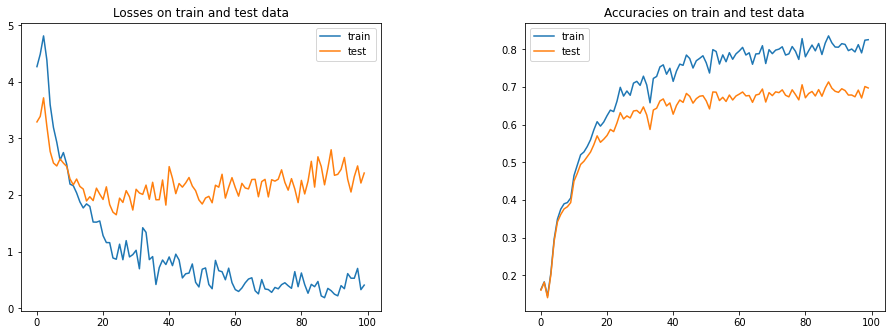

In [12]:

showgraph(train_loss,test_loss,train_accuracy,test_accuracy)